In [1]:
import sys,os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import scipy as sp
from scipy.linalg import pinv as spinv
from sklearn.metrics import pairwise_distances

In [2]:
def operators(s):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    ops = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))
    
    jindex = 0
    for index in range(n_var):
        ops[:,jindex] = s[:,index]
        jindex +=1
    
    for index in range(n_var-1):
        for index1 in range(index+1,n_var):
            ops[:,jindex] = s[:,index]*s[:,index1]
            jindex +=1
            
    return ops

In [3]:
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)

In [4]:
def generate_seqs(n_var,n_seq,n_sample=30,large=False,num_large=4):
    samples = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_sample,replace=True).reshape(n_seq*n_sample,n_var)
    ops = operators(samples)
    n_ops = ops.shape[1]

    w_true = (np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))

    if large and num_large>0: #putting in some large couplings
        indices_large = np.random.choice(range(n_var,n_ops),size=num_large,replace=False)
        for l_index in range(num_large):
            w_true[indices_large[l_index]] *= 10.0

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p = p/np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    
    return w_true,samples[out_samples],p[out_samples],sample_energy[out_samples]

In [5]:
def eps_machine_step(n_seq,w,ops,eps_scale,alpha):
    obs_energies_w = energy_ops(ops,w)
    sec_order = np.tanh(w*eps_scale)
    probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
    max_obs = np.max(probs_w)
    probs_w = np.exp(probs_w - max_obs)
    probs_w /= np.sum(probs_w)
    ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
    
    return alpha*(ops_expect_w - sec_order)

In [6]:
def log_prob_given(s,col,w):
    s_temp = np.copy(s)
    s_temp[:,col] = -s_temp[:,col]
    
    return np.log(1.0/(1.0 + np.exp(energy_ops(operators(s_temp),w)-energy_ops(operators(s),w))))

In [7]:
def tau_update(n_seq,n_var,ops,w):
    sigma_i = ops[:,:n_var]
    
    energy_orig = energy_ops(ops,w)
    prob_sigma_fake = 0.0
    prob_sigma_orig = 0.0
    s_temp1,s_new = np.copy(ops[:,:n_var]),np.copy(ops[:,:n_var])
    for col in range(n_var):        
        s_temp = np.copy(ops[:,:n_var])
        s_temp[:,col] = np.random.choice([1,-1],size=(n_seq))
        
        prob_flip = 1.0/(1.0+np.exp(energy_orig - energy_ops(operators(s_temp),w)))
        
        # 2019.07.21: Tai
        #prob_flip = np.exp(energy_orig - energy_ops(operators(s_temp),w))
        
        rand_choice = prob_flip > np.random.rand(n_seq) # present sigma[col] is less likely
        
        s_temp1[rand_choice,col] = s_temp[rand_choice,col]
        s_new[rand_choice,col] = s_temp[rand_choice,col]
        prob_sigma_fake += np.mean(log_prob_given(s_temp1,col,w))
        s_temp1 = np.copy(ops[:,:n_var])
        prob_sigma_orig += np.mean(log_prob_given(s_temp1,col,w))
    ops_new = operators(s_new)
    return operators(s_temp),ops_new,prob_sigma_orig-prob_sigma_fake

In [8]:
def eps_machine_rbm_EM(w_true,w,s,eps_scale=.01,max_iter=50,alpha=0.05,W_rep=30, RBM=0):
    n_seq,n_var = s.shape
    s_temp = np.copy(s)
    s_temp[:,n_var-RBM:n_var] = np.random.choice([1,-1],size=(n_seq,RBM))
    
    ops = operators(s_temp)
    ops_flip = np.copy(ops)
    prob_sig,eigs_list = [],[]
    for iterate in range(max_iter):
        w_new = np.copy(w)
        
        for w_rep in range(int(W_rep)): #more w updates before trying to update the hidden spins
            delta_w_new = eps_machine_step(n_seq,w_new,ops,eps_scale,alpha)
            if w_rep == 0:
                if iterate > 0: 
                    size_dw_init_prev,size_dw_final_prev = size_dw_init,size_dw
                size_dw_init = nplin.norm(delta_w_new)
            size_dw = nplin.norm(delta_w_new)
            w_new += delta_w_new

            if size_dw/size_dw_init < 0.5: break

        w = np.copy(w_new)
        ops,ops_flip,prob_sigma_orig_fake = tau_update(n_seq,n_var,ops,w)
        prob_sig.append(prob_sigma_orig_fake)

        for ww_rep in range(max(1,int(w_rep/np.sqrt(float(iterate+1))))): #notice how many iterations we're doing!!
            delta_w_flip = eps_machine_step(n_seq,w_new,ops_flip,eps_scale,alpha)
            w_new -= delta_w_flip
        w = w_new
        
    return w

In [9]:
n_var,n_seq = 20,10000
np.random.seed(0)
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0)

In [10]:
n_part = 5000
eps_list = [0.1,0.5,1.0]

n = n_var+int((n_var-1)*n_var*0.5)
w = np.zeros((n,len(eps_list)))
              
for i,eps in enumerate(eps_list):
    print(i,eps)
    np.random.seed(13)
    w_trial = np.random.rand(n) - 0.5
    w[:,i] = eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=30,eps_scale=eps,RBM=0)

0 0.1
1 0.5
2 1.0


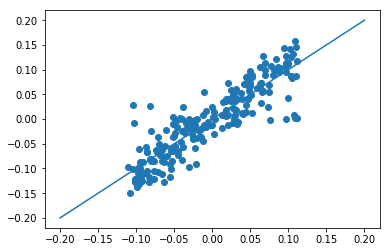

In [11]:
#plt.title('eps = %s'%eps)
plt.plot([-0.2,0.2],[-0.2,0.2])
plt.scatter(w_true,w[:,0])

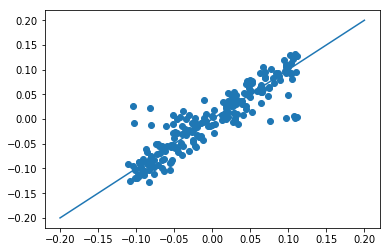

In [12]:
plt.plot([-0.2,0.2],[-0.2,0.2])
plt.scatter(w_true,w[:,1])

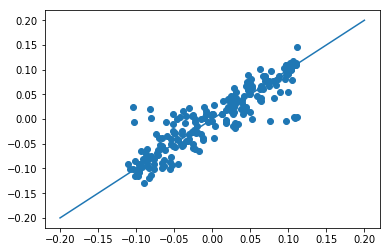

In [13]:
plt.plot([-0.2,0.2],[-0.2,0.2])
plt.scatter(w_true,w[:,2])